In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deepMacroFin import PDEModel
from deepMacroFin import ActivationType, Comparator, EndogVar, EndogVarConditions, EndogEquation

## Model 1
$$\begin{bmatrix}\dot{x} \\ \dot{y}\end{bmatrix} = \begin{bmatrix} x+3y \\ 3x+y\end{bmatrix}, \begin{bmatrix}x(0) \\ y(0)\end{bmatrix} = \begin{bmatrix}1 \\ 0\end{bmatrix}$$

Solution: $\begin{bmatrix} x\\ y \end{bmatrix} = \frac{1}{2}\begin{bmatrix} e^{4t} + e^{-2t}\\ e^{4t} - e^{-2t} \end{bmatrix}$

In [2]:
ode1 = PDEModel("ode_system1")
ode1.set_state(["t"], {"t": [0., 1.]})
ode1.add_endog("x", config={
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "hidden_units": [50, 50, 50],
    "activation_type": ActivationType.Tanh,
    "positive": False,
    "derivative_order": 2,
})
ode1.add_endog("y", config={
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "hidden_units": [50, 50, 50],
    "activation_type": ActivationType.Tanh,
    "positive": False,
    "derivative_order": 2,
})
ode1.add_endog_equation("x_t = x + 3*y", label="base_ode1", weight=0.1)
ode1.add_endog_equation("y_t = 3*x + 1*y", label="base_ode2", weight=0.1)
ode1.add_endog_condition("x", 
                              "x(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "1", {},
                              label="ic_x")
ode1.add_endog_condition("y", 
                              "y(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "0", {},
                              label="ic_y")
print(ode1)
if not os.path.exists("./models/ode_system1.pt"):
    ode1.train_model("./models", "ode_system1.pt", True)
    ode1.eval_model(True)
else:
    ode1.load_model(torch.load("./models/ode_system1.pt"))
    ode1.eval_model(True)

==========================Summary of Model ode_system1==========================
Config: {
 "batch_size": 100,
 "num_epochs": 1000,
 "lr": 0.001
}
Latex Variable Mapping: {}

================================State Variables=================================
t: [0.0, 1.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: x
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=1, out_features=50, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (activation_2): Tanh()
    (final_layer): Linear(in_features=50, out_features=1, bias=True)
  )
)
Num parameters: 5251
----------------------------------------------

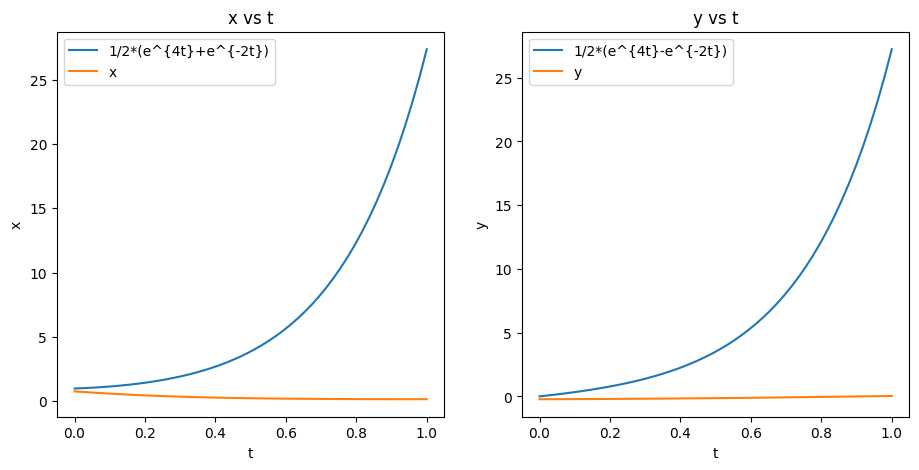

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
t = np.linspace(0., 1)
ax[0].plot(t, 0.5*(np.exp(4*t) + np.exp(-2*t)), label="1/2*(e^{4t}+e^{-2t})")
ax[1].plot(t, 0.5*(np.exp(4*t) - np.exp(-2*t)), label="1/2*(e^{4t}-e^{-2t})")
ode1.endog_vars["x"].plot("x", {"t": [0., 1.]}, ax=ax[0])
ode1.endog_vars["y"].plot("y", {"t": [0., 1.]}, ax=ax[1])
plt.subplots_adjust()
plt.show()

## DeepXDE

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Compiling model...
'compile' took 0.369475 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.82e-01, 2.38e-02, 1.00e+00, 0.00e+00]    [1.84e-01, 2.19e-02, 1.00e+00, 0.00e+00]    [9.91e-01]    
1000      [2.39e-02, 2.31e-02, 2.01e-01, 2.00e-01]    [2.29e-02, 2.14e-02, 2.01e-01, 2.00e-01]    [9.96e-01]    
2000      [2.37e-02, 2.33e-02, 1.99e-01, 2.00e-01]    [2.41e-02, 2.25e-02, 1.99e-01, 2.00e-01]    [9.96e-01]    
3000      [2.96e-02, 1.81e-02, 2.01e-01, 1.99e-01]    [3.08e-02, 1.93e-02, 2.01e-01, 1.99e-01]    [9.94e-01]    
4000      [2.43e-02, 2.44e-02, 1.92e-01, 1.93e-01]    [2.52e-02, 2.53e-02, 1.92e-01, 1.93e-01]    [9.84e-01]    
5000      [2.40e-02, 2.28e-02, 1.78e-01, 1.78e-01]    [2.46e-02, 2.27e-02, 1.78e-01, 1.78e-01]    [9.46e-01]    
6000      [2.19e-02, 1.96e-02, 1.50e-01, 1.50e-01]    [2.32e-02, 1.97e-02, 1.50e-01, 1.50e-01]    [8.70e-01]    
7000      [1.53e-02, 1.45e-02, 

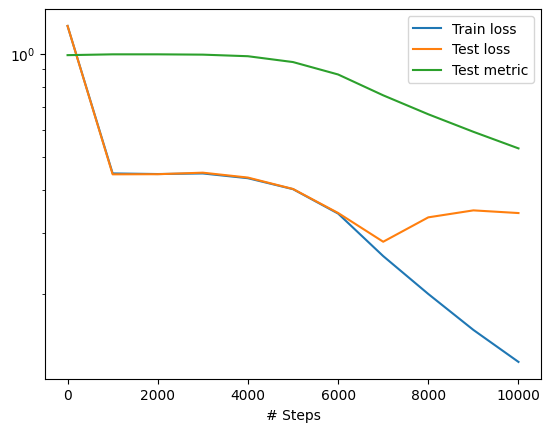

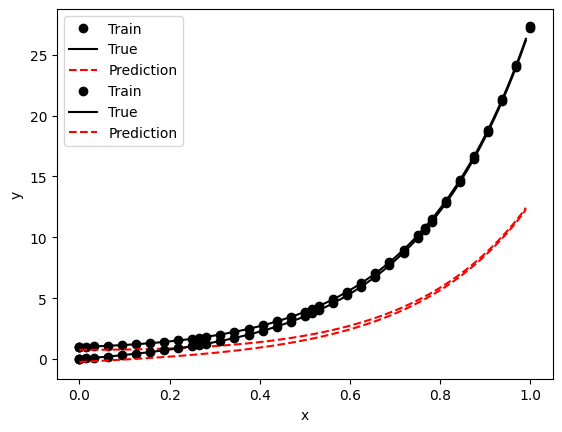

In [4]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np


def ode_system(t, X):
    """ODE system.
    dx/dt = x+3y
    dy/dt = 3x+y
    """
    # Most backends
    x, y = X[:, 0:1], X[:, 1:]
    dx_dt = dde.grad.jacobian(X, t, i=0)
    dy_dt = dde.grad.jacobian(X, t, i=1)
    return [dx_dt - x - 3*y, dy_dt - 3*x-y]


def boundary(_, on_initial):
    return on_initial


def func(t):
    """
    x = 0.5(e^{4t}+e^{-2t})
    y = 0.5(e^{4t}-e^{-2t})
    """
    return 0.5*np.hstack((np.exp(4*t) + np.exp(-2*t), np.exp(4*t) - np.exp(-2*t)))


geom = dde.geometry.TimeDomain(0, 1)
ic1 = dde.icbc.IC(geom, lambda x: 1, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)